# Imports

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

In [43]:
import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger
from torchmetrics import Precision, Recall, F1Score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
np.seed = 42
torch.seed = 42

# Data: FashionMNIST

## utils

In [6]:
def imshow(img):
    img = img.numpy() / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [7]:
batch_size = 64
num_workers = 6

In [14]:
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(90),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [15]:
train_set = torchvision.datasets.FashionMNIST(root='../data', train=True, download=True, transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_set = torchvision.datasets.FashionMNIST(root='../data', train=False, download=True, transform=val_transforms)
val_loader = DataLoader(val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [16]:
for images, labels in train_loader:
    break

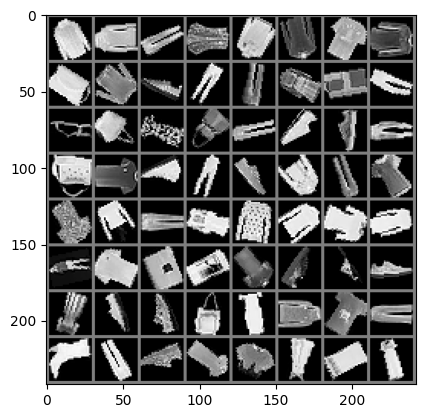

In [17]:
grid_img = torchvision.utils.make_grid(images, nrow=8)
imshow(grid_img)

In [18]:
images.shape

torch.Size([64, 1, 28, 28])

In [19]:
for c in train_set.classes:
    print(f'- {c}')

- T-shirt/top
- Trouser
- Pullover
- Dress
- Coat
- Sandal
- Shirt
- Sneaker
- Bag
- Ankle boot


# Model

## Simple cnn

In [20]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False), # bias false, using bn
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),

        )

        self.neck = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(128, 10),
        )
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        return x

In [21]:
simple_cnn = SimpleCNN()

In [22]:
simple_cnn(images).shape

torch.Size([64, 10])

# Spatial attention

In [75]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        cat = torch.cat([avg_out, max_out], dim=1)
        return self.sigmoid(self.conv1(cat)) * x

In [82]:
class SpatialAttentionCNN(nn.Module):
    def __init__(self):
        super(SpatialAttentionCNN, self).__init__()
        self.backbone = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1, bias=False), # bias false, using bn
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            SpatialAttention(),
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            SpatialAttention(),
        )


        self.neck = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(128, 10),
        )
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        return x

In [83]:
sa_cnn = SpatialAttentionCNN()

In [84]:
sa_cnn(images).shape

torch.Size([64, 10])

# Gated convolutions

In [27]:
class GatedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding, bias=True):
        super(GatedConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias)
        self.gate_conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding, bias=bias)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.conv(x) * self.sigmoid(self.gate_conv(x))

class GatedCNN(nn.Module):
    def __init__(self):
        super(GatedCNN, self).__init__()
        self.backbone = nn.Sequential(
            GatedConv2d(1, 16, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
            
            GatedConv2d(16, 32, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.ReLU(inplace=True),
        )

        self.neck = nn.Flatten()

        self.head = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.BatchNorm1d(128),
            nn.Dropout(0.1),
            nn.GELU(),
            nn.Linear(128, 10),
        )
        

    def forward(self, x):
        x = self.backbone(x)
        x = self.neck(x)
        x = self.head(x)
        return x

In [28]:
gated_cnn = GatedCNN()
gated_cnn(images).shape

torch.Size([64, 10])

# Training loop

In [37]:
class LModule(L.LightningModule):
    def __init__(self, model: nn.Module):
        super(LModule, self).__init__()
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        
        self.precision_micro = Precision('multiclass', num_classes=10, average='micro')
        self.precision_macro = Precision('multiclass', num_classes=10, average='macro')
        self.recall_micro = Recall('multiclass', num_classes=10, average='micro')
        self.recall_macro = Recall('multiclass', num_classes=10, average='macro')
        self.f1_micro = F1Score('multiclass', num_classes=10, average='micro')
        self.f1_macro = F1Score('multiclass', num_classes=10, average='macro')
        

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.loss(outputs, labels)
        self.log('loss/train', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self.model(images)
        loss = self.loss(outputs, labels)
        
        self.log('loss/val', loss)
        preds = torch.argmax(outputs, dim=1)
        
        self.precision_micro(preds, labels)
        self.recall_micro(preds, labels)
        self.f1_micro(preds, labels)
        self.precision_macro(preds, labels)
        self.recall_macro(preds, labels)
        self.f1_macro(preds, labels)

    def on_validation_epoch_end(self):
        self.log('val/micro_precision', self.precision_micro.compute(), prog_bar=True)
        self.log('val/macro_precision', self.precision_macro.compute(), prog_bar=True)
        self.log('val/micro_recall', self.recall_micro.compute(), prog_bar=True)
        self.log('val/macro_recall', self.recall_macro.compute(), prog_bar=True)
        self.log('val/micro_f1', self.f1_micro.compute(), prog_bar=True)
        self.log('val/macro_f1', self.f1_macro.compute(), prog_bar=True)
        
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-4)

In [30]:
max_epocs = 100
log_every_n_steps = 100

In [31]:
simple_module = LModule(simple_cnn)
trainer = L.Trainer(
    max_epochs=max_epocs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs', 'simple_cnn'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [32]:
trainer.fit(simple_module, train_loader, val_dataloaders=val_loader)

You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name            | Type                | Params
--------------------------------------------------------
0 | model           | SimpleCNN           | 207 K 
1 | loss            | CrossEntropyLoss    | 0     
2 | precision_micro | MulticlassPrecision | 0     
3 | precision_macro | MulticlassPrecision | 0     
4 | recall_micro    | MulticlassRecall    | 0     
5 | recall_macro    | MulticlassRecall    | 0     
6 | f1_micro        | MulticlassF1Score   | 0     
7 | f1_macro        | MulticlassF1Score   | 0     
--------------------------------------------------------
207 K     Trainable pa

Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [85]:
sa_cnn = SpatialAttentionCNN()
spatial_attention_module = LModule(sa_cnn)
trainer = L.Trainer(
    max_epochs=max_epocs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs', 'spatial_attention'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [86]:
trainer.fit(spatial_attention_module, train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name            | Type                | Params
--------------------------------------------------------
0 | model           | SpatialAttentionCNN | 207 K 
1 | loss            | CrossEntropyLoss    | 0     
2 | precision_micro | MulticlassPrecision | 0     
3 | precision_macro | MulticlassPrecision | 0     
4 | recall_micro    | MulticlassRecall    | 0     
5 | recall_macro    | MulticlassRecall    | 0     
6 | f1_micro        | MulticlassF1Score   | 0     
7 | f1_macro        | MulticlassF1Score   | 0     
--------------------------------------------------------
207 K     Trainable params
0         Non-trainable params
207 K     Total params
0.830     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [35]:
gated_cnn = GatedCNN()
gated_module = LModule(gated_cnn)
trainer = L.Trainer(
    max_epochs=max_epocs,
    log_every_n_steps=log_every_n_steps,
    logger=TensorBoardLogger('../logs', 'gated'),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [36]:
trainer.fit(gated_module, train_loader, val_dataloaders=val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name            | Type                | Params
--------------------------------------------------------
0 | model           | GatedCNN            | 211 K 
1 | loss            | CrossEntropyLoss    | 0     
2 | precision_micro | MulticlassPrecision | 0     
3 | precision_macro | MulticlassPrecision | 0     
4 | recall_micro    | MulticlassRecall    | 0     
5 | recall_macro    | MulticlassRecall    | 0     
6 | f1_micro        | MulticlassF1Score   | 0     
7 | f1_macro        | MulticlassF1Score   | 0     
--------------------------------------------------------
211 K     Trainable params
0         Non-trainable params
211 K     Total params
0.848     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=100` reached.


In [58]:
def evaluate_model(model, dataloader):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    model.eval()

    precision_micro = Precision('multiclass', num_classes=10, average='micro')
    recall_micro = Recall('multiclass', num_classes=10, average='micro')
    f1_micro = F1Score('multiclass', num_classes=10, average='micro')

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            with torch.inference_mode():
                outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    metrics = {}
    for cls_name, i in dataloader.dataset.class_to_idx.items():
        class_preds = all_preds[all_labels == i]
        class_labels = all_labels[all_labels == i]

        precision = precision_micro(class_preds, class_labels).item()
        recall = recall_micro(class_preds, class_labels).item()
        f1 = f1_micro(class_preds, class_labels).item()

        metrics[cls_name] = {
            'Precision': precision,
            'Recall': recall,
            'F1': f1
        }

    metrics_df = pd.DataFrame.from_dict(metrics, orient='index')
    return metrics_df

In [87]:
simple_metrics = evaluate_model(simple_cnn, val_loader)

In [88]:
simple_metrics

,Precision,Recall,F1
T-shirt/top,0.824,0.824,0.824
Trouser,0.978,0.978,0.978
Pullover,0.852,0.852,0.852
Dress,0.895,0.895,0.895
Coat,0.872,0.872,0.872
Sandal,0.957,0.957,0.957
Shirt,0.653,0.653,0.653
Sneaker,0.969,0.969,0.969
Bag,0.976,0.976,0.976
Ankle boot,0.955,0.955,0.955


In [89]:
sa_metrics = evaluate_model(sa_cnn, val_loader)
sa_metrics

,Precision,Recall,F1
T-shirt/top,0.862,0.862,0.862
Trouser,0.969,0.969,0.969
Pullover,0.892,0.892,0.892
Dress,0.884,0.884,0.884
Coat,0.821,0.821,0.821
Sandal,0.924,0.924,0.924
Shirt,0.671,0.671,0.671
Sneaker,0.968,0.968,0.968
Bag,0.960,0.960,0.960
Ankle boot,0.957,0.957,0.957


In [90]:
gated_metrics = evaluate_model(gated_cnn, val_loader)
gated_metrics

,Precision,Recall,F1
T-shirt/top,0.865,0.865,0.865
Trouser,0.979,0.979,0.979
Pullover,0.842,0.842,0.842
Dress,0.835,0.835,0.835
Coat,0.921,0.921,0.921
Sandal,0.955,0.955,0.955
Shirt,0.656,0.656,0.656
Sneaker,0.949,0.949,0.949
Bag,0.960,0.960,0.960
Ankle boot,0.966,0.966,0.966


In [91]:
names = ['simple', 'sa', 'gated']
dfs = [simple_metrics, sa_metrics, gated_metrics]

unidf = []
for name, df in zip(names, dfs):
    unidf.append(df.add_prefix(f"{name}_"))
unidf = pd.concat(unidf, axis=1)

In [92]:
unidf

,simple_Precision,simple_Recall,simple_F1,sa_Precision,sa_Recall,sa_F1,gated_Precision,gated_Recall,gated_F1
T-shirt/top,0.824,0.824,0.824,0.862,0.862,0.862,0.865,0.865,0.865
Trouser,0.978,0.978,0.978,0.969,0.969,0.969,0.979,0.979,0.979
Pullover,0.852,0.852,0.852,0.892,0.892,0.892,0.842,0.842,0.842
Dress,0.895,0.895,0.895,0.884,0.884,0.884,0.835,0.835,0.835
Coat,0.872,0.872,0.872,0.821,0.821,0.821,0.921,0.921,0.921
Sandal,0.957,0.957,0.957,0.924,0.924,0.924,0.955,0.955,0.955
Shirt,0.653,0.653,0.653,0.671,0.671,0.671,0.656,0.656,0.656
Sneaker,0.969,0.969,0.969,0.968,0.968,0.968,0.949,0.949,0.949
Bag,0.976,0.976,0.976,0.960,0.960,0.960,0.960,0.960,0.960
Ankle boot,0.955,0.955,0.955,0.957,0.957,0.957,0.966,0.966,0.966
